# Fase 1: Preparación de los datos

## Importación de Librerías y Configuración

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import resample  # <--- IMPORTANTE: Para arreglar el desbalanceo

# Para Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## Carga de Datos y Corrección de Desbalanceo

In [ ]:
# Cargar d00.dat y mostrar shape
data_path = os.path.join('../data/TEP_data', 'd00.dat')

if not os.path.exists(data_path):
    print(f"No se encontró el archivo: {data_path}")
else:
    try:
        # Intentar cargar asumiendo separadores por espacios/tabulaciones y cabecera
        df_d00 = pd.read_csv(data_path, delim_whitespace=True, header=0)
    except Exception:
        try:
            # Fallback: usar expresión regular para separar por cualquier espacio en blanco
            df_d00 = pd.read_csv(data_path, sep=r'\s+', engine='python', header=0)
        except Exception:
            # Último recurso: lectura sin procesar (puede fallar si el formato es complejo)
            df_d00 = pd.read_csv(data_path, engine='python')
    
    print(f"Archivo cargado: {data_path}")
    print("Shape:", df_d00.shape)
    print("\nPrimeras filas:")
    print(df_d00.head())

In [59]:
# 1. Definición de columnas y función de carga (Igual que antes)
def load_tep_data(fault_range=range(0, 22), data_dir='../data/TEP_csv'):
    train_data = []
    test_data = []
    
    print("="*60)
    print("CARGANDO DATOS TENNESSEE EASTMAN PROCESS")
    print("="*60)
    
    for fault_id in fault_range:
        file_id = f"{fault_id:02d}"
        train_file = f"d{file_id}.csv"
        test_file = f"d{file_id}_te.csv"
        
        path_train = os.path.join(data_dir, train_file)
        path_test = os.path.join(data_dir, test_file)
        
        if os.path.exists(path_train):
            df_tr = pd.read_csv(path_train)
            train_data.append(df_tr)
            
        if os.path.exists(path_test):
            df_te = pd.read_csv(path_test)
            test_data.append(df_te)
    
    df_train_final = pd.concat(train_data, ignore_index=True)
    df_test_final = pd.concat(test_data, ignore_index=True)
    
    return df_train_final, df_test_final

# Cargar datos
df_train, df_test = load_tep_data()

# --- CORRECCIÓN DE DESBALANCEO (NUEVO) ---
print(f"\nAntes del balanceo - Muestras Normales: {len(df_train[df_train['fault']==0])}")

# Separar clases
df_normal = df_train[df_train['fault'] == 0]
df_faults = df_train[df_train['fault'] != 0]

# Oversampling de la clase Normal (La aumentamos a 5000 muestras para que el modelo la aprenda bien)
df_normal_upsampled = resample(df_normal, 
                               replace=True,     
                               n_samples=5000,   
                               random_state=42)

# Combinar de nuevo
df_train_balanced = pd.concat([df_normal_upsampled, df_faults])

print(f"Después del balanceo - Muestras Normales: {len(df_train_balanced[df_train_balanced['fault']==0])}")
print(f"Total Train Balanceado: {df_train_balanced.shape}")

CARGANDO DATOS TENNESSEE EASTMAN PROCESS

Antes del balanceo - Muestras Normales: 52
Después del balanceo - Muestras Normales: 5000
Total Train Balanceado: (15080, 54)


## Limpieza y Normalización

In [60]:
# Eliminar columnas irrelevantes
columns_to_drop = ['sample', 'fault', 'fault_type']
# Asegurarnos de que existan antes de borrarlas
cols_train = [c for c in columns_to_drop if c in df_train_balanced.columns]
cols_test = [c for c in columns_to_drop if c in df_test.columns]

X_train = df_train_balanced.drop(cols_train, axis=1)
y_train = df_train_balanced['fault']

X_test = df_test.drop(cols_test, axis=1) # El test NO se balancea, debe ser real
y_test = df_test['fault']

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler para la API
joblib.dump(scaler, 'tep_scaler.pkl')
print("✓ Datos normalizados y Scaler guardado.")

✓ Datos normalizados y Scaler guardado.


## Selección de variables

/var/folders/ql/chdr3tpx7pz4ftr0xxsf1sd80000gn/T/ipykernel_49802/1832385260.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


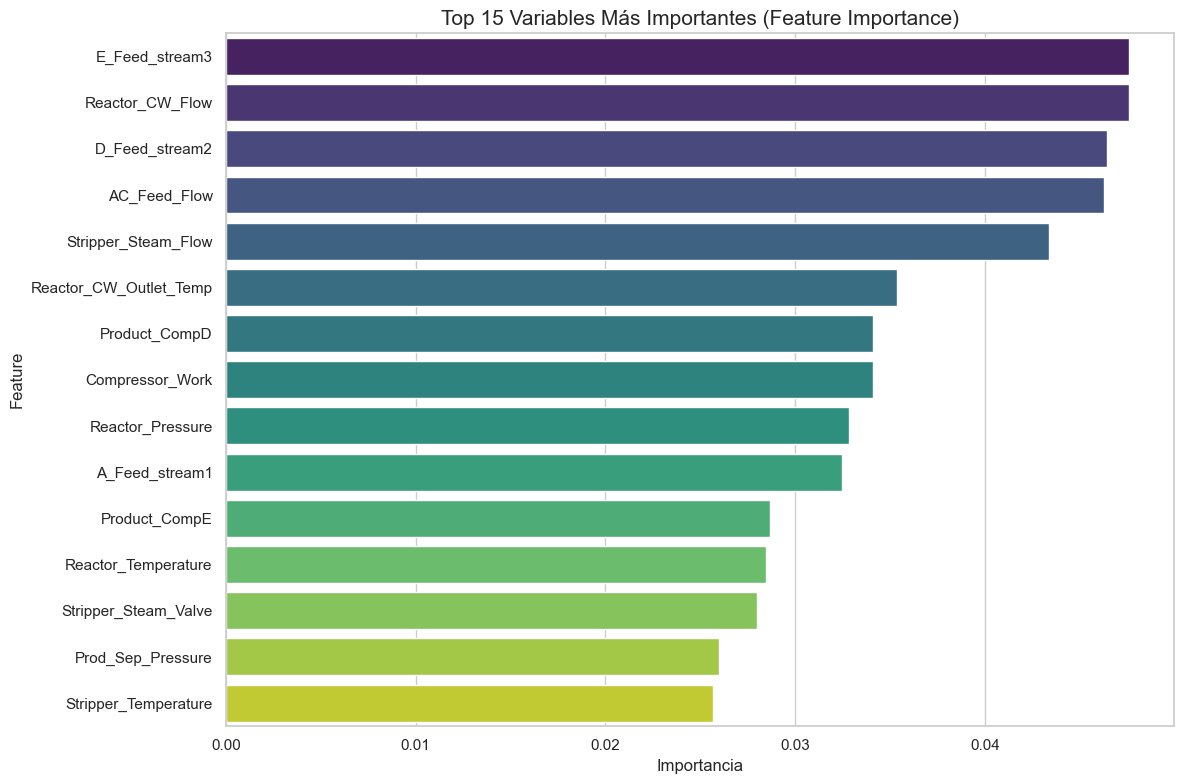

Las 5 variables más críticas son: ['E_Feed_stream3', 'Reactor_CW_Flow', 'D_Feed_stream2', 'AC_Feed_Flow', 'Stripper_Steam_Flow']


In [61]:
# Usamos Random Forest para identificar las variables más importantes
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_scaled, y_train)

# Crear DataFrame de importancia
importances = rf_selector.feature_importances_
feature_names = X_train.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 15 Variables Más Importantes (Feature Importance)', fontsize=15)
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

top_features_list = feature_imp_df['Feature'].tolist()
print("Las 5 variables más críticas son:", top_features_list[:5])

## Visualizacion Temporal

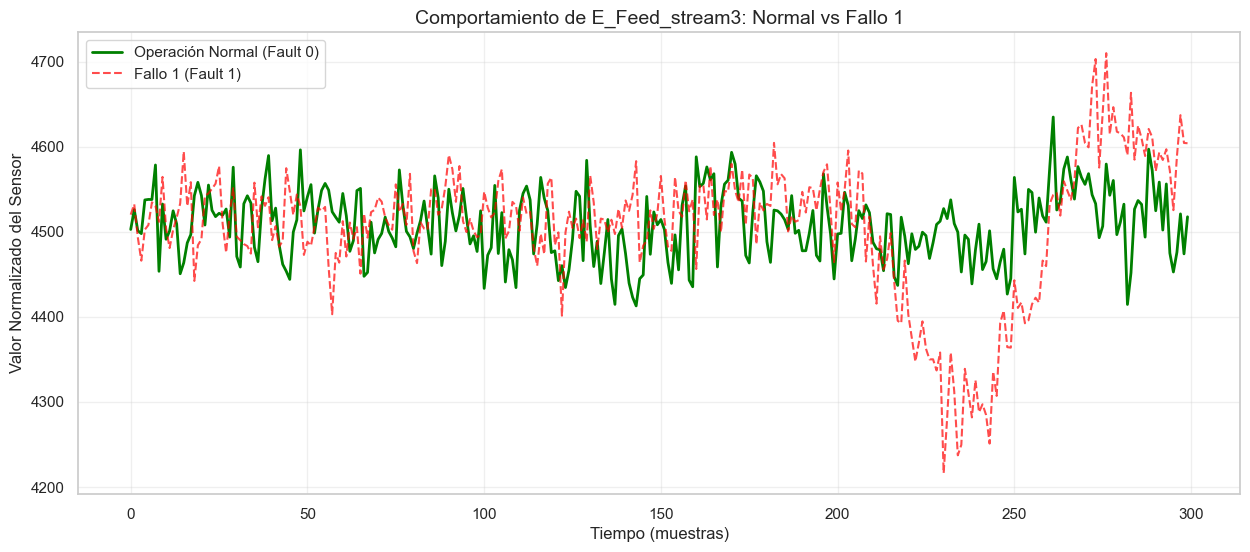

In [62]:
# Tomamos la variable más importante del análisis anterior
top_feature = feature_imp_df.iloc[0]['Feature'] 

plt.figure(figsize=(15, 6))

# 1. Tramo de operación Normal
normal_data = df_test[df_test['fault'] == 0][top_feature].values[:300]
plt.plot(normal_data, label='Operación Normal (Fault 0)', color='green', linewidth=2)

# 2. Tramo de un Fallo (ej: Fallo 1)
fault_data = df_test[df_test['fault'] == 1][top_feature].values[:300]
plt.plot(fault_data, label='Fallo 1 (Fault 1)', color='red', linestyle='--', alpha=0.7)

plt.title(f'Comportamiento de {top_feature}: Normal vs Fallo 1', fontsize=14)
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Valor Normalizado del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Preparación para LSTM (Secuencias)

In [63]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10 

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

# One-hot encoding
num_classes = len(np.unique(y_train))
y_train_lstm_cat = to_categorical(y_train_lstm, num_classes=num_classes)
y_test_lstm_cat = to_categorical(y_test_lstm, num_classes=num_classes)

print("Shape LSTM Train:", X_train_lstm.shape)

Shape LSTM Train: (15070, 10, 52)


## Entrenamiento de Modelos y Comparativa

### Modelo 1: Random Forest

In [64]:
# --- MODELO 1: Random Forest ---
print("Entrenando Random Forest (con datos balanceados)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluar
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Reporte Random Forest Mejorado ---")
print(classification_report(y_test, y_pred_rf))
joblib.dump(rf_model, 'tep_rf_model.pkl')

Entrenando Random Forest (con datos balanceados)...

--- Reporte Random Forest Mejorado ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       960
           1       0.99      0.83      0.90       960
           2       0.97      0.82      0.88       960
           3       0.12      0.24      0.16       960
           4       0.92      0.80      0.86       960
           5       0.59      0.54      0.56       960
           6       1.00      0.83      0.91       960
           7       1.00      0.83      0.91       960
           8       0.71      0.51      0.59       960
           9       0.13      0.20      0.16       960
          10       0.28      0.37      0.32       960
          11       0.83      0.55      0.66       960
          12       0.52      0.65      0.58       960
          13       0.88      0.17      0.29       960
          14       0.94      0.79      0.86       960
          15       0.09      0.28      0.14

/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1

['tep_rf_model.pkl']

### Modelo 2: LSTM

In [74]:
# --- MODELO 2: LSTM ---
from sklearn.utils import shuffle

X_train_lstm, y_train_lstm_cat = shuffle(X_train_lstm, y_train_lstm_cat, random_state=42)

print("Datos barajados. Ahora el entrenamiento será correcto.")


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

print("Entrenando LSTM Mejorado (Arquitectura Profunda)...")

model_lstm = Sequential()

# 1. Primera capa LSTM: Más neuronas y 'return_sequences=True' para conectar con otra LSTM
model_lstm.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model_lstm.add(BatchNormalization()) # Estabiliza el aprendizaje
model_lstm.add(Dropout(0.3))         # Evita memorización pura

# 2. Segunda capa LSTM: Procesa lo que entendió la primera capa
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.3))

# 3. Capa Densa Intermedia: Para procesar características antes de clasificar
model_lstm.add(Dense(64, activation='relu'))

# 4. Capa de Salida: 22 neuronas (una por clase)
model_lstm.add(Dense(num_classes, activation='softmax'))

# Compilación
model_lstm.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

# --- CALLBACKS: La clave para que no se estanque ---
callbacks = [
    # Si la val_loss no mejora en 10 épocas, para y quédate con el mejor modelo
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    
    # Si se estanca 3 épocas, reduce la velocidad de aprendizaje a la mitad
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Entrenamiento
history = model_lstm.fit(
    X_train_lstm, y_train_lstm_cat,
    epochs=50,  
    batch_size=64,
    validation_split=0.2, # Usamos 20% para validar (estándar)
    callbacks=callbacks,  # Añadimos los callbacks
    verbose=1
)

model_lstm.save('tep_lstm_model.keras')
print("Modelo LSTM Mejorado guardado.")

Datos barajados. Ahora el entrenamiento será correcto.
Entrenando LSTM Mejorado (Arquitectura Profunda)...
Epoch 1/50


/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4326 - loss: 1.8637 - val_accuracy: 0.4287 - val_loss: 1.9210 - learning_rate: 0.0010
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5012 - loss: 1.5772 - val_accuracy: 0.4575 - val_loss: 1.6810 - learning_rate: 0.0010
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5316 - loss: 1.4456 - val_accuracy: 0.4751 - val_loss: 1.7194 - learning_rate: 0.0010
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5630 - loss: 1.3329 - val_accuracy: 0.5159 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5842 - loss: 1.2669 - val_accuracy: 0.4595 - val_loss: 3.3503 - learning_rate: 0.0010
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5949 - loss: 1.2264 - val_accuracy: 0.4944 - val_loss: 2.0507 - learning_rate: 0.0010
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5991 - loss: 1.2082
Epoch 

## Evaluación y Matriz de Confusión

660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


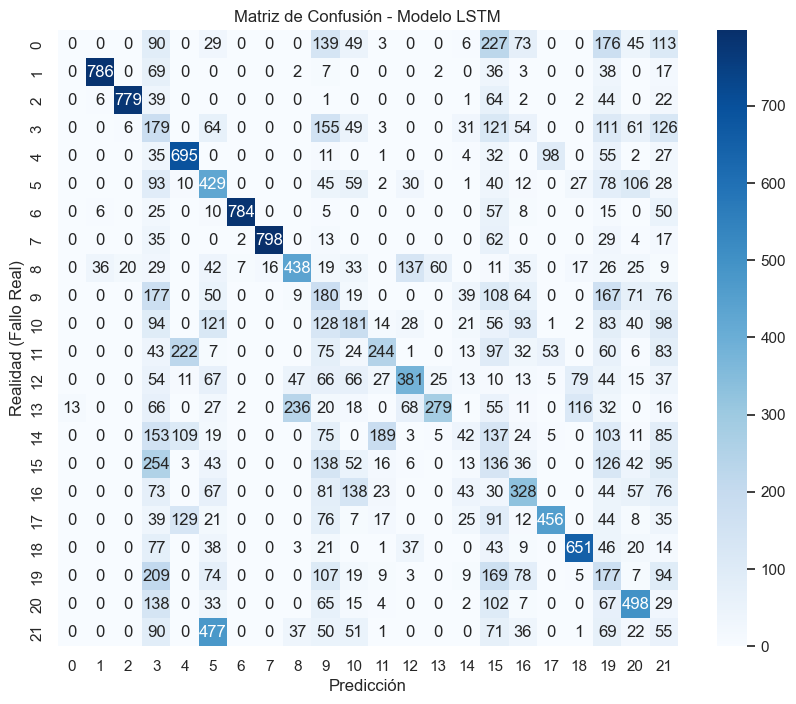

F1-Score Random Forest: 0.5586
F1-Score LSTM: 0.4182


In [75]:
# Predicciones LSTM
y_pred_lstm_prob = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

# Matriz de Confusión (Usando LSTM como ejemplo principal)
cm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Realidad (Fallo Real)")
plt.show()

# Comparativa rápida
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print(f"F1-Score Random Forest: {f1_rf:.4f}")
print(f"F1-Score LSTM: {f1_lstm:.4f}")